# Contextualized Regression
Contextual models allow to identify heterogeneous effects which change between different contexts. The `contextualized` package provides easy access to these heterogeneous models through the `contextualized.easy` module interfaces. This notebook shows a simple example of using `contextualized.easy` regression. 

## 1. Generate Simulation Data
In this simulated regression, we'll study the simple varying-coefficients case where $Y =X\beta(C) + \epsilon$, with $\beta(C) \sim \text{N}(C\phi, \text{I})$, and $\epsilon \sim \text{N}(0, 0.01 \text{I})$. 

- **$Y$**: The dependent or output variable.
- **$X$**: The independent or predictor variable.
- **$\beta(C)$**: The coefficients of the regression model, which vary depending on the context $C$.
- **$C$**: The context variable that influences the coefficients $\beta$.
- **$\phi$**: A parameter vector that influences how the context $C$ impacts the coefficients $\beta(C)$.
- **$I$**: The identity matrix, used to define the variance of the normal distributions.
- **$\epsilon$**: The error term, representing random noise in the data. Can be ignored when predicting $Y$ given $X$.
- **$\sim \text{N}(\mu, \sigma^2)$**: Indicates a normal distribution with mean $\mu$ and variance $\sigma^2$.

In [1]:
import numpy as np
n_samples = 1000
n_outcomes = 3
n_context = 1
n_observed = 1
C = np.random.uniform(-1, 1, size=(n_samples, n_context))
X = np.random.uniform(0, 0.5, size=(n_samples, n_observed))
phi = np.random.uniform(-1, 1, size=(n_context, n_observed, n_outcomes))
beta = np.tensordot(C, phi, axes=1) + np.random.normal(0, 0.01, size=(n_samples, n_observed, n_outcomes))
Y = np.array([np.tensordot(X[i], beta[i], axes=1) for i in range(n_samples)])

## 2. Build and fit model
The `contextualized.easy` models use an sklearn-type wrapper interface. More details about the specific implementation can be found in the [documentation](https://contextualized.ml/docs/source/easy.html).

In [2]:
%%capture
from contextualized.easy import ContextualizedRegressor
model = ContextualizedRegressor()
model.fit(C, X, Y, max_epochs=20, learning_rate=1e-3, n_bootstraps=3)

## 3. Inspect the model predictions.

In [3]:
%%capture
import matplotlib.pyplot as plt
%matplotlib inline
preds = model.predict(C, X)[:, 0]

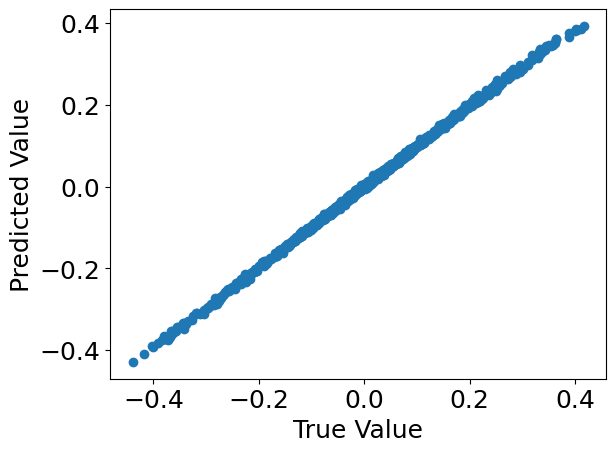

In [4]:
plt.rcParams.update({'font.size': 18})
plt.scatter(Y[:, 0], preds)
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.show()

## 4. Check what the individual bootstrap models learned.
**Bootstrapping** is a resampling method that involves creating multiple samples from the original dataset by sampling with replacement. Each bootstrap sample is used to train different instances of a model, resulting in a collection of models that learned from varying data. This approach improves model robustness and provides insight into the variability of predictions.

For more information, refer to [this resource on bootstrapping](https://en.wikipedia.org/wiki/Bootstrap_(statistics)).


In [5]:
%%capture
model_preds = model.predict(C, X, individual_preds=True)

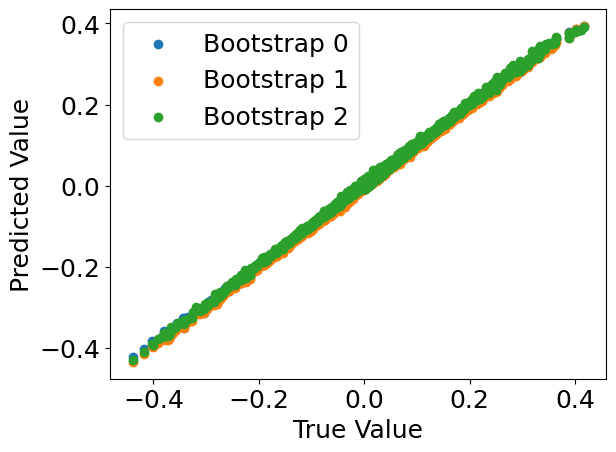

In [6]:
for i, pred in enumerate(model_preds):
    plt.scatter(Y[:, 0], pred[:, 0], label='Bootstrap {}'.format(i))
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.legend()
plt.show()

## 5. Check what parameters the models learned.

In [7]:
%%capture
beta_preds, mu_preds = model.predict_params(C, individual_preds=True)

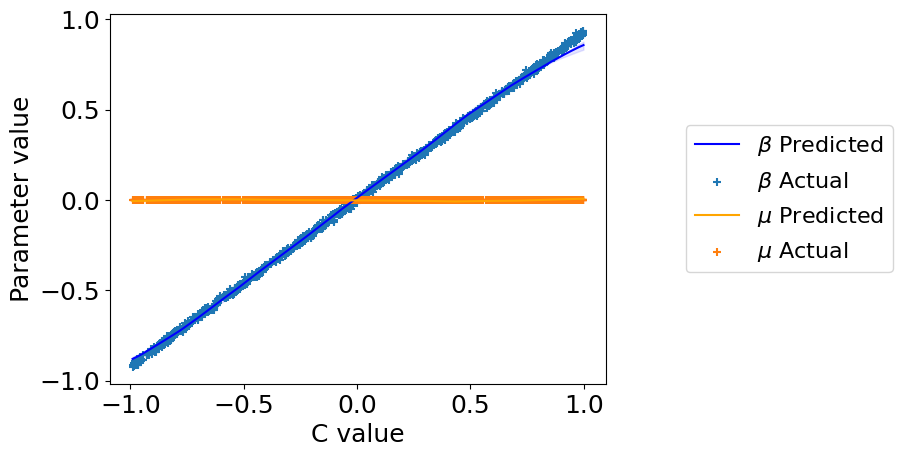

In [8]:
order = np.argsort(C.squeeze())  # put C in order for plotting
C = C[order].squeeze()
beta_preds = beta_preds[:, order]
mu_preds = mu_preds[:, order]
beta = beta[order]

plt.plot(
    C, np.mean(beta_preds[:, :, 0], axis=0),
            label='$\\beta$ Predicted', color='blue')
plt.fill_between(
    C,
    np.percentile(beta_preds[:, :, 0], 2.5, axis=0).squeeze(),
    np.percentile(beta_preds[:, :, 0], 97.5, axis=0).squeeze(),
    color='blue', alpha=0.1
)
plt.scatter(C, beta[:, :, 0], label='$\\beta$ Actual', marker='+')

plt.plot(
    C, np.mean(mu_preds[:, :, 0], axis=0),
            label='$\\mu$ Predicted', color='orange')
plt.fill_between(
    C,
    np.percentile(mu_preds[:, :, 0], 2.5, axis=0).squeeze(),
    np.percentile(mu_preds[:, :, 0], 97.5, axis=0).squeeze(),
    color='orange', alpha=0.1
)
plt.scatter(C, np.zeros_like(C), label='$\\mu$ Actual', marker='+')
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.5), fontsize=16)
plt.xlabel("C value")
plt.ylabel("Parameter value")
plt.show()

## 6. Save/load the trained model.

In [9]:
from contextualized.utils import save, load

save_path = './easy_demo_model.pt'
save(model, path=save_path)
model = load(save_path)

## 7. Further Reading
### For a deeper look
- [Death to Cluster Models; Long Live Context Encoders](https://contextualized.ml/docs/demos/custom_models.html)

### Contextualized regression with real-world data
- [Fitting Contextualized Models](https://contextualized.ml/docs/model-fitting.html)
- [Analyzing Contextualized Models](https://contextualized.ml/docs/model-analysis.html)

### API Reference
- [Models](https://contextualized.ml/docs/source/easy.html#)
- [Analysis](https://contextualized.ml/docs/source/analysis.html)